# 通过强化学习学习提示变量注入

通过将特定术语注入模板句子中，可以增强LLM提示。选择正确的术语对于获得高质量的回答至关重要。本笔记本介绍了使用VowpalWabbit的强化学习通过术语注入进行自动提示工程。

rl_chain（强化学习链）提供了一种自动确定最佳注入术语的方法，无需对基础模型进行微调。

为了说明，考虑一个餐饮外卖服务的场景。我们使用LangChain向顾客（如Tom）询问他们的饮食偏好，并从我们丰富的菜单中推荐适合的餐点。rl_chain根据用户的偏好选择一份餐点，将其注入到提示模板中，并将提示转发给LLM。然后将LLM的响应（个性化推荐）返回给用户。

下面的示例是一个玩具示例，用于演示该概念的适用性。高级选项和解释将在最后提供。

In [ ]:
# 安装必要的包
# ! pip install langchain langchain-experimental matplotlib vowpal_wabbit_next sentence-transformers pandas

In [2]:
# 定义了四个餐点，其中一些是素食，一些不是

meals = [
    "Beef Enchiladas with Feta cheese. Mexican-Greek fusion",  # 牛肉恩奇拉达配菲塔奶酪。墨西哥-希腊融合
    "Chicken Flatbreads with red sauce. Italian-Mexican fusion",  # 鸡肉薄饼配红酱。意大利-墨西哥融合
    "Veggie sweet potato quesadillas with vegan cheese",  # 素食甜薯饼配纯素奶酪
    "One-Pan Tortelonni bake with peppers and onions",  # 一锅烤托特洛尼意面配辣椒和洋葱
]

In [3]:
# 选择并配置您选择的LLM（语言模型）

from langchain_openai import OpenAI

# 创建一个OpenAI对象，并指定使用的模型为"gpt-3.5-turbo-instruct"
llm = OpenAI(model="gpt-3.5-turbo-instruct")

##### 使用提供的默认值初始化RL链

需要定义将用于查询LLM的提示模板。
它可以是任何内容，但这里使用了`{meal}`，将被上面的其中一餐替换，RL链将尝试选择并注入最佳餐点


In [4]:
from langchain.prompts import PromptTemplate

# 在这里，我使用变量meal，它将被上面的一餐替换
# 还有一些变量，如user、preference和text_to_personalize，我将在链运行时提供

PROMPT_TEMPLATE = """这是一餐的描述: "{meal}".

将这餐嵌入到给定的文本中: "{text_to_personalize}".

在开头添加一个包含用户姓名"{user}"和他们的偏好"{preference}"的个性化消息。

让它听起来不错。
"""

PROMPT = PromptTemplate(
    input_variables=["meal", "text_to_personalize", "user", "preference"],
    template=PROMPT_TEMPLATE,
)

接下来，RL链的PickBest链正在初始化。我们必须提供所选择的llm和定义的提示。正如名称所示，该链的目标是根据某些标准挑选提供的餐点中的最佳选择。

In [5]:
# 导入langchain_experimental包中的rl_chain模块
import langchain_experimental.rl_chain as rl_chain

# 使用rl_chain模块中的PickBest类的from_llm方法，传入llm和prompt参数，赋值给chain变量
chain = rl_chain.PickBest.from_llm(llm=llm, prompt=PROMPT)

一旦链条设置好了，我将使用我想要从中选择的餐点以及一些基于上下文的信息来调用它，然后链条将选择一顿餐。

In [6]:
# 定义一个response变量，使用chain.run方法运行一系列操作
response = chain.run(
    # 选择餐点
    meal=rl_chain.ToSelectFrom(meals),
    # 基于用户Tom
    user=rl_chain.BasedOn("Tom"),
    # 基于用户的偏好，包括素食和普通乳制品
    preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    # 个性化文本信息
    text_to_personalize="This is the weeks specialty dish, our master chefs \
        believe you will love it!",
)

In [7]:
# 输出response字典中"response"键对应的值
print(response["response"])

Hey Tom! We've got a special treat for you this week - our master chefs have cooked up a delicious One-Pan Tortelonni Bake with peppers and onions, perfect for any Vegetarian who is ok with regular dairy! We know you'll love it!


## 链的作用是什么

以下是强化学习链操作的逐步分解：

1. 接受餐点列表。
2. 考虑用户及其饮食偏好。
3. 基于此上下文，选择适当的餐点。
4. 自动评估餐点选择的适当性。
5. 将选择的餐点注入提示中并提交给LLM。
6. 将LLM的响应返回给用户。

从技术上讲，该链通过使用上下文强化学习模型来实现，具体使用了[VowpalWabbit](https://github.com/VowpalWabbit/vowpal_wabbit)机器学习库。

最初，由于RL模型未经训练，它可能会选择与用户偏好不一致的随机选择。然而，随着对用户选择和反馈的了解越来越多，它应该开始做出更好的选择（或者快速学习一个好的选择并选择它！）。

In [8]:
# 循环5次
for _ in range(5):
    try:
        # 使用chain.run方法运行代码
        response = chain.run(
            meal=rl_chain.ToSelectFrom(meals),  # 选择餐点
            user=rl_chain.BasedOn("Tom"),  # 基于Tom用户
            preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),  # 基于偏好
            text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",  # 个性化文本
        )
    except Exception as e:
        print(e)
    print(response["response"])  # 打印响应
    print()  # 打印空行

Hey Tom! We know you love vegetarian dishes and that regular dairy is ok, so this week's specialty dish is perfect for you! Our master chefs have created a delicious Chicken Flatbread with red sauce - a unique Italian-Mexican fusion that we know you'll love. Enjoy!

Hey Tom, this week's specialty dish is a delicious Mexican-Greek fusion of Beef Enchiladas with Feta cheese to suit your preference of 'Vegetarian' with 'regular dairy is ok'. Our master chefs believe you will love it!

Hey Tom! Our master chefs have cooked up something special this week - a Mexican-Greek fusion of Beef Enchiladas with Feta cheese - and we know you'll love it as a vegetarian-friendly option with regular dairy included. Enjoy!

Hey Tom! We've got the perfect meal for you this week - our delicious veggie sweet potato quesadillas with vegan cheese, made with the freshest ingredients. Even if you usually opt for regular dairy, we think you'll love this vegetarian dish!

Hey Tom! Our master chefs have outdone th

## 链式学习是如何进行的

需要注意的是，虽然强化学习模型可以进行复杂的选择，但它并不会本能地识别"素食主义者"这样的概念，也不会理解"牛肉墨西哥卷饼"不适合素食主义者。相反，它利用LLM将选择与常识联系起来。

链式学习通过内置在链中的AutoSelectionScorer来学习Tom偏爱素食餐。评分器将再次调用LLM，并要求其使用包含在BasedOn中的信息来评估选择（ToSelectFrom）。

如果您想查看自动评分器的详细信息，可以设置`set_debug(True)`，但您也可以自定义评分提示。

In [9]:
# 定义评分标准模板
scoring_criteria_template = (
    "Given {preference} rank how good or bad this selection is {meal}"
)

# 创建一个PickBest对象，使用llm作为参数
chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=rl_chain.AutoSelectionScorer(
        llm=llm, scoring_criteria_template_str=scoring_criteria_template
    ),
)

如果你想要检查分数和其他选择元数据，你可以通过检查由链返回的元数据对象来实现。

In [10]:
# 定义一个名为response的变量，调用chain的run方法
response = chain.run(
    # 传入参数meal，值为rl_chain.ToSelectFrom(meals)
    meal=rl_chain.ToSelectFrom(meals),
    # 传入参数user，值为rl_chain.BasedOn("Tom")
    user=rl_chain.BasedOn("Tom"),
    # 传入参数preference，值为rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"])
    preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    # 传入参数text_to_personalize，值为"This is the weeks specialty dish, our master chefs believe you will love it!"
    text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",
)
# 打印response中的"response"键对应的值
print(response["response"])
# 获取response中的"selection_metadata"键对应的值，赋值给selection_metadata变量
selection_metadata = response["selection_metadata"]
# 打印选定项的索引和分数
print(
    f"selected index: {selection_metadata.selected.index}, score: {selection_metadata.selected.score}"
)

Hey Tom, this week's meal is something special! Our chefs have prepared a delicious One-Pan Tortelonni Bake with peppers and onions - vegetarian friendly and made with regular dairy, so you can enjoy it without worry. We know you'll love it!
selected index: 3, score: 0.5


在一个更加现实的场景中，很可能你已经为所选内容定义了一个明确定义的评分函数。例如，你可能正在进行少样本提示，并希望为自然语言到SQL翻译任务选择提示示例。在这种情况下，评分者可以是：生成的SQL是否在SQL引擎中运行？在这种情况下，你希望插入一个评分函数。在下面的示例中，我将仅检查所选的餐是否为素食。

In [11]:
class CustomSelectionScorer(rl_chain.SelectionScorer):
    def score_response(
        self, inputs, llm_response: str, event: rl_chain.PickBestEvent
    ) -> float:
        print(event.based_on)  # 打印基于的信息
        print(event.to_select_from)  # 打印可供选择的信息

        # 在这里可以构建一个复杂的评分函数
        # 最好的情况是评分在0到1之间，但不强制要求

        selected_meal = event.to_select_from["meal"][event.selected.index]  # 获取选择的餐点
        print(f"selected meal: {selected_meal}")  # 打印选择的餐点

        if "Tom" in event.based_on["user"]:
            if "Vegetarian" in event.based_on["preference"]:
                if "Chicken" in selected_meal or "Beef" in selected_meal:
                    return 0.0  # 如果用户是Tom且偏好素食，且选择的餐点中包含鸡肉或牛肉，则返回0.0
                else:
                    return 1.0  # 如果用户是Tom且偏好素食，且选择的餐点中不包含鸡肉或牛肉，则返回1.0
            else:
                if "Chicken" in selected_meal or "Beef" in selected_meal:
                    return 1.0  # 如果用户是Tom但不偏好素食，且选择的餐点中包含鸡肉或牛肉，则返回1.0
                else:
                    return 0.0  # 如果用户是Tom但不偏好素食，且选择的餐点中不包含鸡肉或牛肉，则返回0.0
        else:
            raise NotImplementedError("I don't know how to score this user")  # 如果用户不是Tom，则抛出NotImplementedError异常，表示无法对该用户进行评分

In [12]:
# 从llm中创建一个PickBest对象的链
chain = rl_chain.PickBest.from_llm(
    llm=llm,  # 使用给定的llm模型
    prompt=PROMPT,  # 使用给定的PROMPT作为提示
    selection_scorer=CustomSelectionScorer(),  # 使用自定义的选择评分器
)

In [13]:
# 使用rl_chain模块的ToSelectFrom方法选择菜品
# 使用rl_chain模块的BasedOn方法基于用户"Tom"选择菜品
# 使用rl_chain模块的BasedOn方法基于用户的偏好选择菜品
# 设置要个性化的文本信息
response = chain.run(
    meal=rl_chain.ToSelectFrom(meals),
    user=rl_chain.BasedOn("Tom"),
    preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",
)

{'user': ['Tom'], 'preference': ['Vegetarian', 'regular dairy is ok']}
{'meal': ['Beef Enchiladas with Feta cheese. Mexican-Greek fusion', 'Chicken Flatbreads with red sauce. Italian-Mexican fusion', 'Veggie sweet potato quesadillas with vegan cheese', 'One-Pan Tortelonni bake with peppers and onions']}
selected meal: Veggie sweet potato quesadillas with vegan cheese


## 如何跟踪链的进展

您可以使用提供的度量机制来跟踪链的进展。我将扩展用户为Tom和Anna，并扩展评分函数。我将初始化两个链，一个使用默认的学习策略，另一个使用内置的随机策略（即随机选择一餐），并绘制它们的评分进展。

In [14]:
# 自定义选择评分器类，继承自SelectionScorer类
class CustomSelectionScorer(rl_chain.SelectionScorer):
    def score_preference(self, preference, selected_meal):
        # 如果用户偏好中包含"Vegetarian"
        if "Vegetarian" in preference:
            # 如果选中的餐点中包含"Chicken"或"Beef"
            if "Chicken" in selected_meal or "Beef" in selected_meal:
                return 0.0
            else:
                return 1.0
        else:
            # 如果选中的餐点中包含"Chicken"或"Beef"
            if "Chicken" in selected_meal or "Beef" in selected_meal:
                return 1.0
            else:
                return 0.0

    def score_response(
        self, inputs, llm_response: str, event: rl_chain.PickBestEvent
    ) -> float:
        # 获取选中的餐点
        selected_meal = event.to_select_from["meal"][event.selected.index]

        # 如果基于用户的信息中包含"Tom"
        if "Tom" in event.based_on["user"]:
            # 根据用户偏好评分选中的餐点
            return self.score_preference(event.based_on["preference"], selected_meal)
        # 如果基于用户的信息中包含"Anna"
        elif "Anna" in event.based_on["user"]:
            # 根据用户偏好评分选中的餐点
            return self.score_preference(event.based_on["preference"], selected_meal)
        else:
            # 抛出未实现错误
            raise NotImplementedError("I don't know how to score this user")

In [15]:
# 创建一个链式模型，使用PickBest策略
chain = rl_chain.PickBest.from_llm(
    llm=llm,  # 使用llm作为模型
    prompt=PROMPT,  # 设置提示文本
    selection_scorer=CustomSelectionScorer(),  # 使用自定义的选择评分器
    metrics_step=5,  # 每5个步骤计算一次指标
    metrics_window_size=5,  # 指标计算的滚动窗口大小为5
)

# 创建一个随机链式模型，使用PickBest策略
random_chain = rl_chain.PickBest.from_llm(
    llm=llm,  # 使用llm作为模型
    prompt=PROMPT,  # 设置提示文本
    selection_scorer=CustomSelectionScorer(),  # 使用自定义的选择评分器
    metrics_step=5,  # 每5个步骤计算一次指标
    metrics_window_size=5,  # 指标计算的滚动窗口大小为5
    policy=rl_chain.PickBestRandomPolicy,  # 设置随机策略，而不是默认策略
)

In [16]:
# 循环20次
for _ in range(20):
    try:
        # 使用chain运行指定参数的函数
        chain.run(
            meal=rl_chain.ToSelectFrom(meals),  # 选择餐点
            user=rl_chain.BasedOn("Tom"),  # 用户为Tom
            preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),  # 偏好为素食和普通乳制品
            text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",  # 个性化文本
        )
        # 使用random_chain运行指定参数的函数
        random_chain.run(
            meal=rl_chain.ToSelectFrom(meals),  # 选择餐点
            user=rl_chain.BasedOn("Tom"),  # 用户为Tom
            preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),  # 偏好为素食和普通乳制品
            text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",  # 个性化文本
        )

        # 使用chain运行指定参数的函数
        chain.run(
            meal=rl_chain.ToSelectFrom(meals),  # 选择餐点
            user=rl_chain.BasedOn("Anna"),  # 用户为Anna
            preference=rl_chain.BasedOn(["Loves meat", "especially beef"]),  # 偏好为喜欢肉类，尤其是牛肉
            text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",  # 个性化文本
        )
        # 使用random_chain运行指定参数的函数
        random_chain.run(
            meal=rl_chain.ToSelectFrom(meals),  # 选择餐点
            user=rl_chain.BasedOn("Anna"),  # 用户为Anna
            preference=rl_chain.BasedOn(["Loves meat", "especially beef"]),  # 偏好为喜欢肉类，尤其是牛肉
            text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",  # 个性化文本
        )
    except Exception as e:
        print(e)  # 捕获异常并打印

强化学习链收敛到一个事实，即安娜更喜欢牛肉而汤姆是素食主义者。随机链随机选择，因此会有一半的时间将牛肉送给素食主义者。

The final average score for the default policy, calculated over a rolling window, is: 1.0
The final average score for the random policy, calculated over a rolling window, is: 0.6


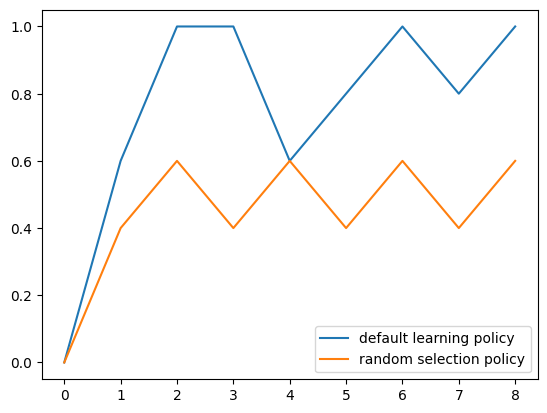

In [17]:
# 导入必要的库
from matplotlib import pyplot as plt

# 将默认学习策略的分数绘制成图表
chain.metrics.to_pandas()["score"].plot(label="默认学习策略")
# 将随机选择策略的分数绘制成图表
random_chain.metrics.to_pandas()["score"].plot(label="随机选择策略")
# 添加图例
plt.legend()

# 打印默认策略在滚动窗口内计算得到的最终平均分数
print(
    f"默认策略的最终平均分数，通过滚动窗口计算得到: {chain.metrics.to_pandas()['score'].iloc[-1]}"
)
# 打印随机策略在滚动窗口内计算得到的最终平均分数
print(
    f"随机策略的最终平均分数，通过滚动窗口计算得到: {random_chain.metrics.to_pandas()['score'].iloc[-1]}"
)

rl_chain的选择过程中涉及一定的随机性，因为该链会探索选择空间以尽可能地学习世界（有关默认探索算法的详细信息请参见[此处](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-Exploration-with-SquareCB)），但总体而言，默认链策略应该比随机策略表现更好，因为它在学习过程中逐渐改进。

## 高级选项

RL链具有高度可配置性，以便能够适应各种选择场景。如果您想了解支持其的ML库，请查看这里的教程：[链接](https://vowpalwabbit.org/)

| 部分 | 描述 | 示例/用法 |
|---------|-------------|-----------------|
| [**更改链日志级别**](#change-chain-logging-level) | 更改RL链的日志级别。 | `logger.setLevel(logging.INFO)` |
| [**特征化**](#featurization) | 调整RL链的输入。可以设置自动嵌入以获得更复杂的嵌入。 | `chain = rl_chain.PickBest.from_llm(auto_embed=True, [...])` |
| [**异步学习策略**](#learned-policy-to-learn-asynchronously) | 如果需要用户输入进行评分，则异步进行评分。 | `chain.update_with_delayed_score(score=<得分>, chain_response=response)` |
| [**存储学习策略的进展**](#store-progress-of-learned-policy) | 存储变量注入学习策略的进展选项。 | `chain.save_progress()` |
| [**停止学习学习策略**](#stop-learning-of-learned-policy) | 切换RL链的学习策略更新开/关。 | `chain.deactivate_selection_scorer()` |
| [**设置不同策略**](#set-a-different-policy) | 选择不同的策略：默认、随机或自定义。 | 在链创建时自定义策略 |
| [**默认学习策略的不同探索算法和选项**](#different-exploration-algorithms-and-options-for-the-default-learned-policy) | 为`VwPolicy`设置不同的探索算法和超参数。 | `vw_cmd = ["--cb_explore_adf", "--quiet", "--squarecb", "--interactions=::"]` |
| [**学习策略的数据日志**](#learned-policys-data-logs) | 存储和检查`VwPolicy`的数据日志。 | `chain = rl_chain.PickBest.from_llm(vw_logs=<日志文件路径>, [...])` |
| [**其他高级特征化选项**](#other-advanced-featurization-options) | 为RL链指定高级特征化选项。 | `age = rl_chain.BasedOn("age:32")` |
| [**有关自动或自定义选择评分器的更多信息**](#more-info-on-auto-or-custom-selectionscorer) | 深入了解选择评分是如何确定的。 | `selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, scoring_criteria_template_str=scoring_criteria_template)` |

### 更改链日志级别

```python
import logging
logger = logging.getLogger("rl_chain")
logger.setLevel(logging.INFO)
```

### 特征化

#### 自动嵌入

默认情况下，RL链的输入（`ToSelectFrom`，`BasedOn`）不会被篡改。这可能不足以进行特征化，因此根据场景的复杂程度，可以将自动嵌入设置为ON。

`chain = rl_chain.PickBest.from_llm(auto_embed=True, [...])`

这将产生更复杂的嵌入和特征化的输入，可能加快RL链的学习速度，但会增加运行时间成本。

默认情况下，将使用[sbert.net的sentence_transformers的](https://www.sbert.net/docs/pretrained_models.html#model-overview) `all-mpnet-base-v2` 模型进行这些嵌入，但您可以通过在链的初始化中使用不同的嵌入模型来设置不同的嵌入模型，如此示例所示。您还可以设置完全不同的嵌入编码对象，只要它具有返回编码列表的`encode()`函数。

```python
from sentence_transformers import SentenceTransformer

chain = rl_chain.PickBest.from_llm(
    [...]
    feature_embedder=rl_chain.PickBestFeatureEmbedder(
        auto_embed=True,
        model=SentenceTransformer("all-mpnet-base-v2")
    )
)
```

#### 明确定义的嵌入

另一个选项是手动定义应该嵌入的输入：
- `auto_embed = False`
- 可以将单独的变量包装在`rl_chain.Embed()`或`rl_chain.EmbedAndKeep()`中，例如`user = rl_chain.BasedOn(rl_chain.Embed("Tom"))`

#### 自定义特征化

另一个最后的选项是定义和设置一个自定义的特征化/嵌入类，该类返回学习策略的有效输入。

## 异步学习策略

如果需要用户输入来评分结果（例如，我的应用向Tom显示了选定的餐点，Tom点击了它，但Anna没有），则评分可以异步进行。方法是：

- 在链创建时设置`selection_scorer=None`，或调用`chain.deactivate_selection_scorer()`
- 调用特定输入的链
- 保留链的响应（`response = chain.run([...])`）
- 一旦确定了响应/链选择的分数，使用该分数调用链：`chain.update_with_delayed_score(score=<得分>, chain_response=response)`

### 存储学习策略的进展

由于变量注入学习策略随时间演变，有选项来存储其进展并继续学习。可以通过调用以下方式实现：

`chain.save_progress()`

这将把rl链的学习策略存储在一个名为`latest.vw`的文件中。它还将在带有时间戳的文件中存储它。这样，如果多次调用`save_progress()`，将创建多个检查点，但最新的检查点始终在`latest.vw`中。

下次加载链时，链将查找名为`latest.vw`的文件，如果文件存在，它将被加载到链中，并且学习将从那里继续。

默认情况下，rl链模型检查点将存储在当前目录中，但您可以在链创建时指定保存/加载位置：

`chain = rl_chain.PickBest.from_llm(model_save_dir=<目录路径>, [...])`

### 停止学习学习策略

如果要停止更新rl链的学习策略，可以将其关闭/打开：

`chain.deactivate_selection_scorer()` 和 `chain.activate_selection_scorer()`

### 设置不同策略

目前有两种可用的策略：

- 默认策略：`VwPolicy`，学习[Vowpal Wabbit](https://github.com/VowpalWabbit/vowpal_wabbit) [Contextual Bandit](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms)模型

- 随机策略：`RandomPolicy`，不学习任何内容，只是随机选择一个值。此策略可用于将其他策略与随机基线策略进行比较。

- 自定义策略：可以在链创建时创建自定义策略并设置。

### 默认学习策略的不同探索算法和选项

默认的`VwPolicy`使用一些默认参数进行初始化。默认的探索算法是[SquareCB](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-Exploration-with-SquareCB)，但可以设置其他Contextual Bandit探索算法，并调整其他超参数（有关可用选项，请参见[此处](https://vowpalwabbit.org/docs/vowpal_wabbit/python/9.6.0/command_line_args.html)）。

`vw_cmd = ["--cb_explore_adf", "--quiet", "--squarecb", "--interactions=::"]`

`chain = rl_chain.PickBest.from_llm(vw_cmd = vw_cmd, [...])`

### 学习策略的数据日志

`VwPolicy`的数据文件可以存储和检查，或用于进行[离线策略评估](https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/off_policy_evaluation.html)以进行超参数调整。

方法是在链创建时将日志文件路径设置为`vw_logs`：

`chain = rl_chain.PickBest.from_llm(vw_logs=<日志文件路径>, [...])`

### 其他高级特征化选项

可以使用冒号分隔符提供明确的数值特征：
`age = rl_chain.BasedOn("age:32")`

如果情景需要，`ToSelectFrom`可以更复杂一些，而不是仅仅是字符串列表：
- 字符串列表的列表：
    ```
    meal = rl_chain.ToSelectFrom([
        ["餐点1名称", "餐点1描述"],
        ["餐点2名称", "餐点2描述"]
    ])
    ```
- 字典列表：
    ```
    meal = rl_chain.ToSelectFrom([
        {"name":"餐点1名称", "description" : "餐点1描述"},
        {"name":"餐点2名称", "description" : "餐点2描述"}
    ])
    ```
- 包含列表的字典列表：
    ```
    meal = rl_chain.ToSelectFrom([
        {"name":["餐点1", "复杂名称"], "description" : "餐点1描述"},
        {"name":["餐点2", "复杂名称"], "description" : "餐点2描述"}
    ])
    ```

`BasedOn`也可以接受字符串列表：
```
user = rl_chain.BasedOn(["Tom Joe", "age:32", "加利福尼亚州"])
```

由于提供了多个变量，因此没有提供字典，而是将其包装在`BasedOn`中。

将数据日志存储到文件中允许检查不同输入对数据格式的影响。

### 关于自动或自定义选择评分器的更多信息

选择评分器非常重要，因为策略使用它来学习。它确定了在强化学习中称为奖励的内容，更具体地说，在我们的Contextual Bandits设置中。

一般建议将分数保持在[0, 1]之间，0表示最差的选择，1表示从可用的`ToSelectFrom`变量中的最佳选择，基于`BasedOn`变量，但如果需要，应进行调整。

在上面提供的示例中，AutoSelectionScorer主要用于让用户开始，但在实际场景中，它很可能不是一个合适的评分器函数。

示例还提供了更改AutoSelectionScorer用于确定选择是否好的部分评分提示模板的选项：

```
scoring_criteria_template = "给定{preference}排名，评价这个选择{meal}的好坏"
chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, scoring_criteria_template_str=scoring_criteria_template),
)

```

在内部，AutoSelectionScorer调整了评分提示，以确保llm评分返回单个浮点数。

但如果需要，也可以提供完整的评分提示：

In [18]:
# 导入必要的模块
from langchain.globals import set_debug
from langchain.prompts.prompt import PromptTemplate

# 设置调试模式为True
set_debug(True)

# 定义奖励提示模板
REWARD_PROMPT_TEMPLATE = """

给定{preference}排名，评价这个选择对{meal}的好坏

重要提示：你必须返回一个介于-1和1之间的数字，-1表示不好，1表示好

"""

# 创建奖励提示
REWARD_PROMPT = PromptTemplate(
    input_variables=["preference", "meal"],
    template=REWARD_PROMPT_TEMPLATE,
)

# 从llm中选择最佳选项
chain = rl_chain.PickBest.from_llm(
    llm=llm,
    prompt=PROMPT,
    selection_scorer=rl_chain.AutoSelectionScorer(llm=llm, prompt=REWARD_PROMPT),
)

# 运行链条
chain.run(
    meal=rl_chain.ToSelectFrom(meals),
    user=rl_chain.BasedOn("Tom"),
    preference=rl_chain.BasedOn(["Vegetarian", "regular dairy is ok"]),
    text_to_personalize="This is the weeks specialty dish, our master chefs believe you will love it!",
)

[chain/start] [1:chain:PickBest] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:PickBest > 2:chain:LLMChain] Entering Chain run with input:
[inputs]
[llm/start] [1:chain:PickBest > 2:chain:LLMChain > 3:llm:OpenAI] Entering LLM run with input:
{
  "prompts": [
    "Here is the description of a meal: \"Chicken Flatbreads with red sauce. Italian-Mexican fusion\".\n\nEmbed the meal into the given text: \"This is the weeks specialty dish, our master chefs believe you will love it!\".\n\nPrepend a personalized message including the user's name \"Tom\" \n    and their preference \"['Vegetarian', 'regular dairy is ok']\".\n\nMake it sound good."
  ]
}
[llm/end] [1:chain:PickBest > 2:chain:LLMChain > 3:llm:OpenAI] [1.12s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\nHey Tom, we have something special for you this week! Our master chefs have created a delicious Italian-Mexican fusion Chicken Flatbreads with red sauce just for you. Our chefs h

{'response': 'Hey Tom, we have something special for you this week! Our master chefs have created a delicious Italian-Mexican fusion Chicken Flatbreads with red sauce just for you. Our chefs have also taken into account your preference of vegetarian options with regular dairy - this one is sure to be a hit!',
 'selection_metadata': <langchain_experimental.rl_chain.pick_best_chain.PickBestEvent at 0x289764220>}